## Automatic ticket clssifcation 

#### <font color= Purple>Problem Statement:</font>

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [71]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [5]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
df.shape

(78313, 22)

## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
#print the column names
print("Column names:" , df.columns.values)

Column names: ['_index' '_type' '_id' '_score' '_source.tags' '_source.zip_code'
 '_source.complaint_id' '_source.issue' '_source.date_received'
 '_source.state' '_source.consumer_disputed' '_source.product'
 '_source.company_response' '_source.company' '_source.submitted_via'
 '_source.date_sent_to_company' '_source.company_public_response'
 '_source.sub_product' '_source.timely' '_source.complaint_what_happened'
 '_source.sub_issue' '_source.consumer_consent_provided']


In [9]:
#Assign new column names
df.rename(columns={'_index': 'index',
 '_type': 'type',
 '_id': 'id',
 '_score': 'score',
 '_source.tags': 'tags',
 '_source.zip_code': 'zip_code',
 '_source.complaint_id': 'complaint_id',
 '_source.issue': 'issue',
 '_source.date_received': 'date_recieved',
 '_source.state': 'state',
 '_source.consumer_disputed': 'consumer_disputed',
 '_source.product': 'product',
 '_source.company_response': 'company_response',
 '_source.company': 'company',
 '_source.submitted_via': 'submitted_via',
 '_source.date_sent_to_company': 'date_sent_to_company',
 '_source.company_public_response': 'company_public_response',
 '_source.sub_product': 'sub_product',
 '_source.timely': 'timely',
 '_source.complaint_what_happened': 'complaint_description',
 '_source.sub_issue': 'sub_issue',
 '_source.consumer_consent_provided': 'consumer_consent_provided'}, inplace=True)

In [10]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_recieved,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_description,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
#Assign nan in place of blanks in the complaints column
df['complaint_description'].replace('', np.nan, inplace=True)

In [12]:
# Null value count after replacinf blanks with nan
df['complaint_description'].isnull().sum()

57241

In [14]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_description'], inplace=True)

In [15]:
# Null value count in 'complaint_description' column after dropping the nan values
df['complaint_description'].isnull().sum()

0

In [16]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [17]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_cleaning(text):
    text=text.lower() # convert text to lower case
    text=re.sub(r'^\[[\w\s]\]+$',' ',text) # removing the text in square brackets
    text=re.sub(r'[^\w\s]',' ',text) # removing punctuation
    text=re.sub(r'[a-zA-Z]\d+\w*$',' ',text) # removing text with numbers
    return text

In [18]:
#Write your function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lematize(text):
    lemma_sent = []
    for doc in tqdm(nlp.pipe(text)):
        sent = [token.lemma_ for token in doc if token.text not in set(stopwords)]
        lemma_sent.append(' '.join(sent))
    return lemma_sent

In [19]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()

In [22]:
# Cleaning the text columns
df_clean['complaint_description'] = df['complaint_description'].apply(lambda x: text_cleaning(x))

In [25]:
df_clean['complaint_description_lemmatized'] = lematize(df_clean['complaint_description'])

21072it [39:25,  8.91it/s]


In [26]:
## Including 'category' and 'sub-category' in the cleaned df to help us identify the topic
df_clean['category'] = df['product']
df_clean['sub_category'] = df['sub_product']

In [27]:
#Write your function to extract the POS tags 

def pos_tag(text):
  pos_sent = []
  for doc in tqdm(nlp.pipe(text)):
    sent = [token.text for token in doc if token.tag_ == 'NN']
    pos_sent.append(' '.join(sent))
  return pos_sent

In [28]:
## creating a column that contains the pos tags of the lemmatized text with all the words removed which have tags other than 'NN'
df_clean['complaint_POS'] = pos_tag(df_clean['complaint_description_lemmatized'])

21072it [09:13, 38.05it/s]


In [29]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_description,complaint_description_lemmatized,category,sub_category,complaint_POS
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [31]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint_description'].str.len()
df_clean['complaint_description_lemmatized_length'] = df_clean['complaint_description_lemmatized'].str.len()
df_clean['complaint_POS_length'] = df_clean['complaint_POS'].str.len()

fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_length'], name='Complaint'))
fig.add_trace(go.Histogram(x=df_clean['complaint_description_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_length'], name='Complaint POS'))
fig.update_layout(barmode='overlay', title='Complaint Character length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.7)
fig.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [ ]:
from wordcloud import WordCloud
wordcloud=WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

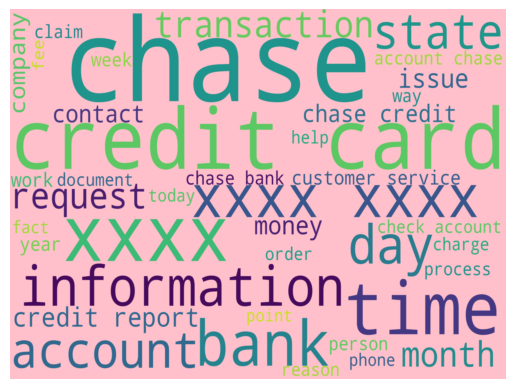

In [34]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopwords, background_color='pink', width=3000, height=2000, max_words=40).generate(' '.join(df_clean['complaint_POS']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [35]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [36]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_30_words(corpus, n=None, count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse= True)
    return words_freq[:count]

In [37]:
#Print the top 10 words in the unigram frequency
unigram = get_top_30_words(df_clean["Complaint_clean"], 1,10)
for word, freq in unigram:
    print(word, freq)
px.bar(x=[word for word, freq in unigram], y=[freq for word, freq in unigram], title='Top 10 unigrams')

chase 58460
xxxx 52900
account 43065
credit 33912
card 30137
payment 21329
bank 19978
time 16233
charge 15387
day 13243


In [46]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram = get_top_30_words(df_clean["Complaint_clean"], 2,30)
for word, freq in bigram:
    print(word, freq)
px.bar(x=[word for word, freq in bigram], y=[freq for word, freq in bigram], title='Top 30 bigrams')

credit card 12862
xxxx xxxx 6127
credit report 3927
chase credit 3170
customer service 3004
call chase 2956
chase bank 2579
account chase 2507
check account 2349
chase account 2114
contact chase 2073
xxxx chase 1950
debit card 1923
account xxxx 1871
bank account 1855
xxxx credit 1819
number xxxx 1765
credit score 1715
account account 1669
xxxx payment 1641
chase card 1625
payment xxxx 1558
card account 1528
card chase 1513
card xxxx 1328
interest rate 1300
chase xxxx 1290
phone number 1244
letter chase 1239
business day 1231


In [47]:
#Print the top 10 words in the bigram frequency
bigram = get_top_30_words(df_clean["Complaint_clean"], 2,10)
for word, freq in bigram:
    print(word, freq)
px.bar(x=[word for word, freq in bigram], y=[freq for word, freq in bigram], title='Top 10 bigrams')

credit card 12862
xxxx xxxx 6127
credit report 3927
chase credit 3170
customer service 3004
call chase 2956
chase bank 2579
account chase 2507
check account 2349
chase account 2114


In [48]:
#Print the top 10 words in the trigram frequency
trigram = get_top_30_words(df_clean["Complaint_clean"], 3,10)
for word, freq in trigram:
    print(word, freq)
px.bar(x=[word for word, freq in trigram], y=[freq for word, freq in trigram], title='Top 10 trigrams')

chase credit card 2275
xxxx xxxx xxxx 1713
credit card account 1061
credit card company 977
xxxx credit card 825
credit card chase 762
chase customer service 579
credit card xxxx 550
inquiry credit report 472
credit card credit 411


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [49]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [50]:
#All masked texts has been removed
df_clean.head()

,complaint_description,complaint_description_lemmatized,category,sub_category,complaint_POS,complaint_length,complaint_description_lemmatized_length,complaint_POS_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,224,149,94,chase card report application submit identity ...
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,1502,839,409,book ticket ticket reward card information off...
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [51]:
#Write your code here to initialise the TfidfVectorizer 
TF_IDF_vec = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [52]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = TF_IDF_vec.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [53]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [54]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [56]:
nmf_model.fit(dtm)
len(TF_IDF_vec.get_feature_names_out())

6257

In [59]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'The Top 15 words topic number { index} with tf_idf score')
    print([TF_IDF_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

The Top 15 words topic number 0 with tf_idf score
['claim', 'customer', 'transaction', 'business', 'number', 'transfer', 'day', 'branch', 'fund', 'chase', 'deposit', 'money', 'bank', 'check', 'account']


The Top 15 words topic number 1 with tf_idf score
['service', 'time', 'reason', 'application', 'month', 'point', 'purchase', 'year', 'limit', 'score', 'account', 'balance', 'chase', 'credit', 'card']


The Top 15 words topic number 2 with tf_idf score
['date', 'statement', 'balance', 'property', 'rate', 'pay', 'year', 'time', 'home', 'modification', 'month', 'chase', 'mortgage', 'loan', 'payment']


The Top 15 words topic number 3 with tf_idf score
['dispute', 'letter', 'score', 'theft', 'remove', 'file', 'identity', 'account', 'reporting', 'debt', 'information', 'company', 'credit', 'inquiry', 'report']


The Top 15 words topic number 4 with tf_idf score
['statement', 'time', 'email', 'contact', 'service', 'fraud', 'purchase', 'refund', 'claim', 'merchant', 'transaction', 'chase', 'f

In [61]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topics_int = nmf_model.transform(dtm)
topics_int.argmax(axis=1)


array([0, 1, 3, ..., 3, 1, 2])

In [62]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topics_int.argmax(axis=1)

In [63]:
df_clean.head()

,complaint_description,complaint_description_lemmatized,category,sub_category,complaint_POS,complaint_length,complaint_description_lemmatized_length,complaint_POS_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...,1
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,224,149,94,chase card report application submit identity ...,3
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,1502,839,409,book ticket ticket reward card information off...,3
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...,0


In [64]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaint_description,complaint_description_lemmatized,category,sub_category,complaint_POS,complaint_length,complaint_description_lemmatized_length,complaint_POS_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...,0
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,Vehicle loan or lease,Loan,mishandle account chase auto xxxx,51,33,33,mishandle account chase auto,0
17,with out notice j p morgan chase restricted m...,notice j p morgan chase restrict account deb...,Checking or savings account,Checking account,account debit card branch customer service rep...,2277,1315,638,account debit card branch customer service rep...,0
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...,0
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus ...,Checking or savings account,Checking account,account call follow term account xxxx deposit ...,413,202,102,account call follow term account deposit bonu...,0
32,my chase amazon card was declined for a cateri...,chase amazon card decline catering order place...,Credit card or prepaid card,General-purpose credit card or charge card,catering order place contact chase noon today ...,1972,1125,573,catering order place contact chase noon today ...,1
59,i currently have over xxxx chase ultimate rewa...,currently xxxx chase ultimate reward point w...,Credit card or prepaid card,General-purpose credit card or charge card,xxxx reward point month access chase reward ac...,1897,1155,551,reward point month access chase reward accoun...,1
52,my roommate was stealing my chase debit card a...,roommate steal chase debit card driver license...,Checking or savings account,Checking account,roommate chase debit card driver license money...,843,556,210,roommate chase debit card driver license money...,1
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...,1
50,i am a senior citizen that has been scammed by...,senior citizen scamme company xxxx xxxx pay ...,Credit card or prepaid card,General-purpose credit card or charge card,citizen time share company refund credit card ...,350,153,65,citizen time share company refund credit card ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [66]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [67]:
df_clean.head()

,complaint_description,complaint_description_lemmatized,category,sub_category,complaint_POS,complaint_length,complaint_description_lemmatized_length,complaint_POS_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...,Bank Account services
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...,Credit card or prepaid card
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,224,149,94,chase card report application submit identity ...,Theft/Dispute Reporting
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,1502,839,409,book ticket ticket reward card information off...,Theft/Dispute Reporting
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

### Checking for Class Imbalance

In [74]:
## Plot to visualize if there is class imbalance present
px.bar(x=training_data['Topic'].value_counts().index, y=training_data['Topic'].value_counts().values/max(training_data['Topic'].value_counts().values), title='Class Imbalance')

In [75]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Bank Account services': 0,
    'Credit card or prepaid card': 1,
    'Others': 2,
    'Theft/Dispute Reporting': 3,
    'Mortgage/Loan': 4 
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [76]:
df_clean.head()

,complaint_description,complaint_description_lemmatized,category,sub_category,complaint_POS,complaint_length,complaint_description_lemmatized_length,complaint_POS_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...,1
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,224,149,94,chase card report application submit identity ...,3
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,1502,839,409,book ticket ticket reward card information off...,3
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...,0


In [77]:
#Keep the columns"complaint_description" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_description','Topic']]

In [78]:
training_data.head()

,complaint_description,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,1
10,chase card was reported on xx xx 2019 however...,3
11,on xx xx 2018 while trying to book a xxxx xx...,3
14,my grand son give me check for 1600 00 i de...,0


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [80]:
vec_count = CountVectorizer()
#Write your code to get the Vector count
X_train_counts = vec_count.fit_transform(training_data['complaint_description'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [83]:
## Importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [85]:
## Spliting the training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.2, random_state=40)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (16857, 29725)
y_train Shape: (16857,)
X_test Shape: (4215, 29725)
y_test Shape: (4215,)


In [99]:
# Define a function for model evaluation
def evaluate_model_performance(y_true, y_pred, model_label):
    
    # Display the classification report for the given model
    print(f"Classification Report for {model_label}\n")
    print(classification_report(y_true, y_pred, target_names=["Bank Account Services", "Credit Card or Prepaid Card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]))
    
    # Generate and display the confusion matrix for the model
    plt.figure(figsize=(10, 7))
    plt.title(f"Confusion Matrix for {model_label}\n")
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, cbar=False, cmap="Greens", fmt='d', xticklabels=["Bank Account Services", "Credit Card or Prepaid Card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"], yticklabels=["Bank Account Services", "Credit Card or Prepaid Card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"])
    plt.show()

    return

### Model 1: Naive Bayes

In [95]:
# Run the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [96]:
# Hyperparameter tuning for best result
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [97]:
# Running model with best hyperparameter
model_name = 'NAIVE BAYES'
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

In [98]:
# Calculate F1 Score of model using weighted average method
f1_NB = f1_score(y_test,y_pred_nb_tuned,average='weighted').round(2)
f1_NB

0.76

In [100]:
# Creating a dataframe to store F1 Scores of all models we will build
F1_summary = pd.DataFrame([{'Model': 'Naive Bayes','F1 Score': round(f1_NB, 2)}])
F1_summary

,Model,F1 Score
0,Naive Bayes,0.76


Classification Report for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account Services       0.77      0.85      0.81      1032
Credit Card or Prepaid Card       0.69      0.64      0.66       778
                     Others       0.82      0.81      0.82      1009
    Theft/Dispute Reporting       0.74      0.75      0.75       473
              Mortgage/Loan       0.74      0.70      0.72       923

                   accuracy                           0.76      4215
                  macro avg       0.75      0.75      0.75      4215
               weighted avg       0.76      0.76      0.76      4215



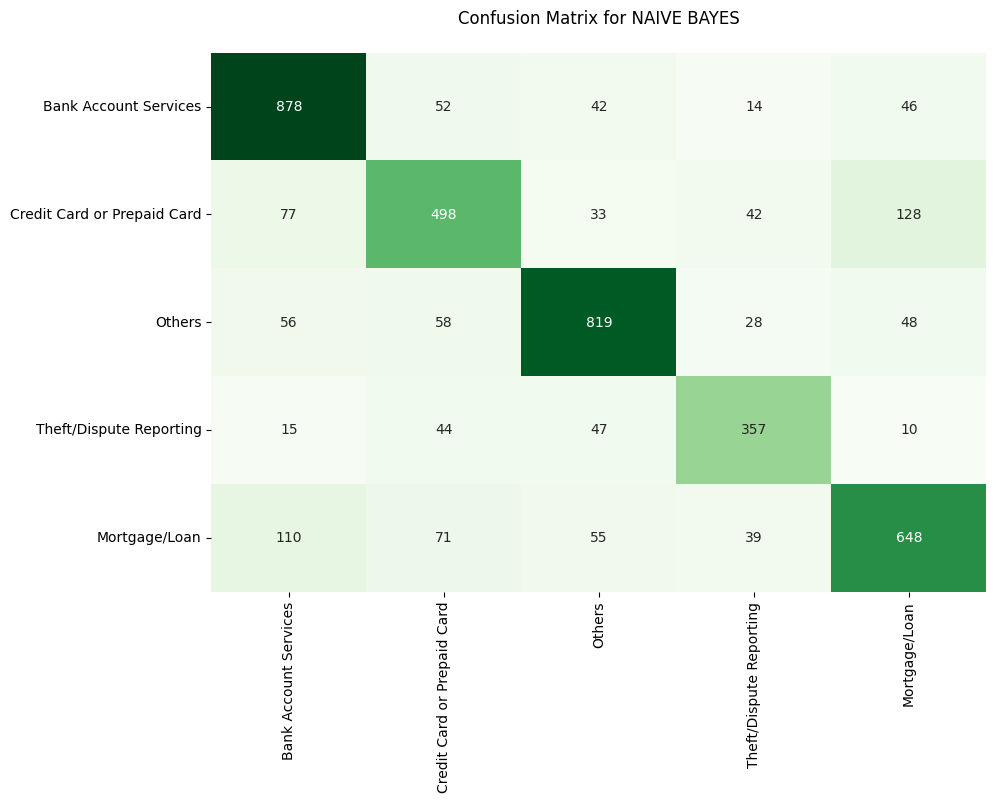

In [101]:
## Evaluating Naive Bayes model
evaluate_model_performance(y_test, y_pred_nb_tuned, model_name)

### Model 2: Logistic Regression

In [102]:
# Running Logistic Regression model with default parameters
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression() 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [104]:
# Initialize the logistic regression model with increased max_iter
lr = LogisticRegression(max_iter=1000)

# Define the parameter grid for hyperparameter tuning
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']  # Only solvers that support l1 penalty
}

# Initialize GridSearchCV with the logistic regression model and the parameter grid
grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)

# Fit the model to the training data
grid_lr.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters found: ", grid_lr.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters found:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [105]:
# Building the model with  the best hyperparameter
lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='liblinear')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [106]:
# Calculate F1 Score of tuned lr model using weighted average method
F1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
F1_lr

0.9287994011295325

In [107]:
# Update the F1 score summary table
F1_summary.loc[len(F1_summary.index)] = ['Logistic Regression', round(F1_lr, 2)]
F1_summary

,Model,F1 Score
0,Naive Bayes,0.76
1,Logistic Regression,0.93


Classification Report for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account Services       0.94      0.95      0.94      1032
Credit Card or Prepaid Card       0.91      0.94      0.93       778
                     Others       0.93      0.96      0.95      1009
    Theft/Dispute Reporting       0.95      0.88      0.91       473
              Mortgage/Loan       0.92      0.89      0.90       923

                   accuracy                           0.93      4215
                  macro avg       0.93      0.92      0.93      4215
               weighted avg       0.93      0.93      0.93      4215



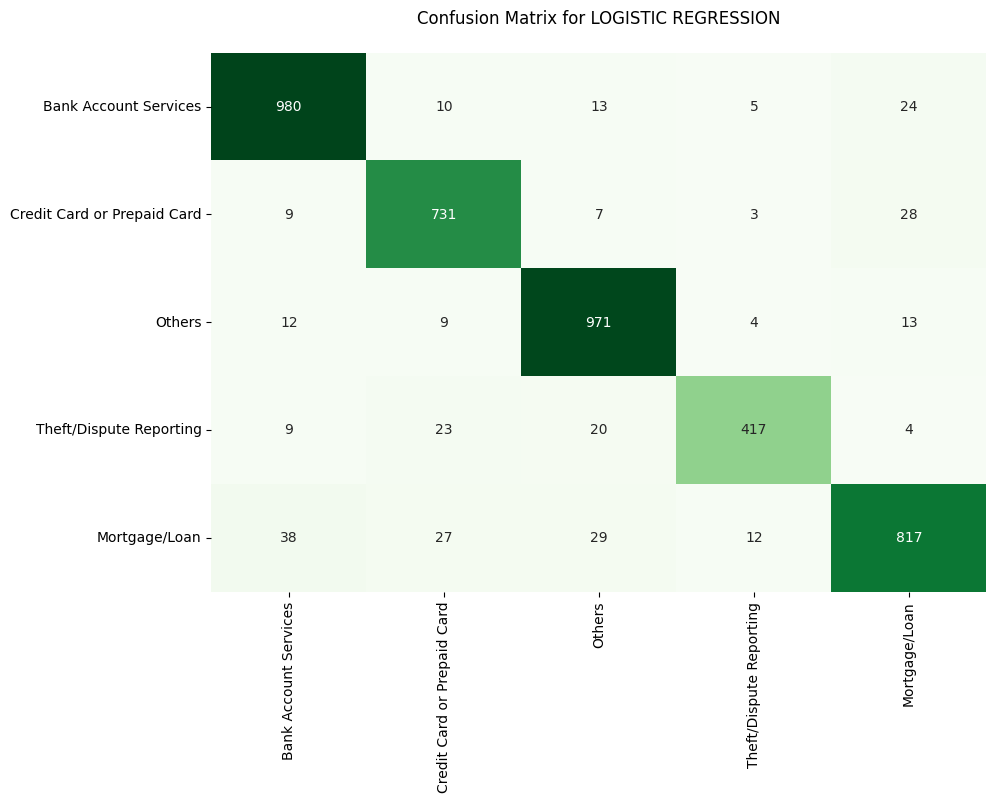

In [108]:
## Evaluating Logistic Regression model
evaluate_model_performance(y_test, y_pred_lr_tuned, model_name)

### Model 3: Decision Tree

In [109]:
# Running Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [110]:
# Hyperparameter tuning for Decision Tree
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 20}


In [111]:
# Building model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='entropy', 
                                      max_depth=20, 
                                      min_samples_leaf=20, 
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [112]:
# Calculate F1 Score of tuned Decision Tree model 
F1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
F1_dt

0.7727906475833638

In [113]:
# Updating the F1 score summary table with the score for decision tree model
F1_summary.loc[len(F1_summary.index)] = ['Decision Tree', round(F1_dt, 2)]
F1_summary

,Model,F1 Score
0,Naive Bayes,0.76
1,Logistic Regression,0.93
2,Decision Tree,0.77


Classification Report for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account Services       0.78      0.80      0.79      1032
Credit Card or Prepaid Card       0.77      0.81      0.79       778
                     Others       0.83      0.84      0.83      1009
    Theft/Dispute Reporting       0.77      0.70      0.74       473
              Mortgage/Loan       0.71      0.67      0.69       923

                   accuracy                           0.77      4215
                  macro avg       0.77      0.77      0.77      4215
               weighted avg       0.77      0.77      0.77      4215



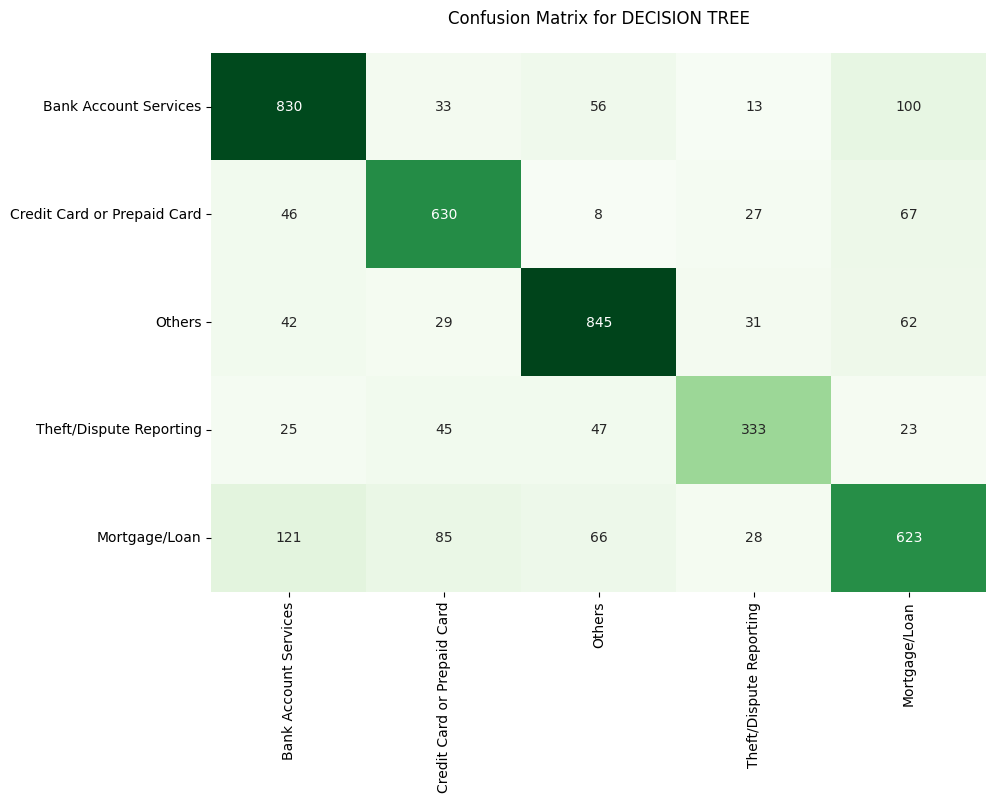

In [114]:
## Evaluating Decision Tree model
evaluate_model_performance(y_test, y_pred_dt_tuned, model_name)

### Model 4: Random Forest

In [141]:
# Running Random Forest with default hyperparameters
model_name = 'RANDOM FOREST'
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [142]:
# Define the parameter grid for Random Forest
param_rf = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Setup GridSearchCV
grid_rf = GridSearchCV(estimator=rf,
                           param_grid=param_rf,
                           scoring='f1_weighted',
                           n_jobs=-1,
                           cv=5,
                           verbose=1)

# Fit GridSearchCV to the training data
grid_rf.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_rf.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/Users/ayang/Documents/Assignments/assignments/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [143]:
# Building Random Forest model with best hyperparameters
rf_tuned = RandomForestClassifier(
    n_estimators=200,  # Number of trees in the forest
    criterion='gini',  # Function to measure the quality of a split
    max_depth=None,  # Maximum depth of the tree
    min_samples_split=5,  # Minimum number of samples required to split an internal node
    min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
    bootstrap=True  # Whether bootstrap samples are used when building trees
)

# Fit the model to the training data
rf_tuned.fit(X_train, y_train)

# Predict on the test data
y_pred_rf_tuned = rf_tuned.predict(X_test)

In [144]:
# Calculate F1 Score of tuned Random Forest model 
F1_rf = f1_score(y_test, y_pred_rf_tuned, average="weighted")
F1_rf

0.8242329678032146

Classification Report for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account Services       0.80      0.93      0.86      1032
Credit Card or Prepaid Card       0.81      0.75      0.78       778
                     Others       0.85      0.91      0.88      1009
    Theft/Dispute Reporting       0.88      0.72      0.79       473
              Mortgage/Loan       0.82      0.74      0.78       923

                   accuracy                           0.83      4215
                  macro avg       0.83      0.81      0.82      4215
               weighted avg       0.83      0.83      0.82      4215



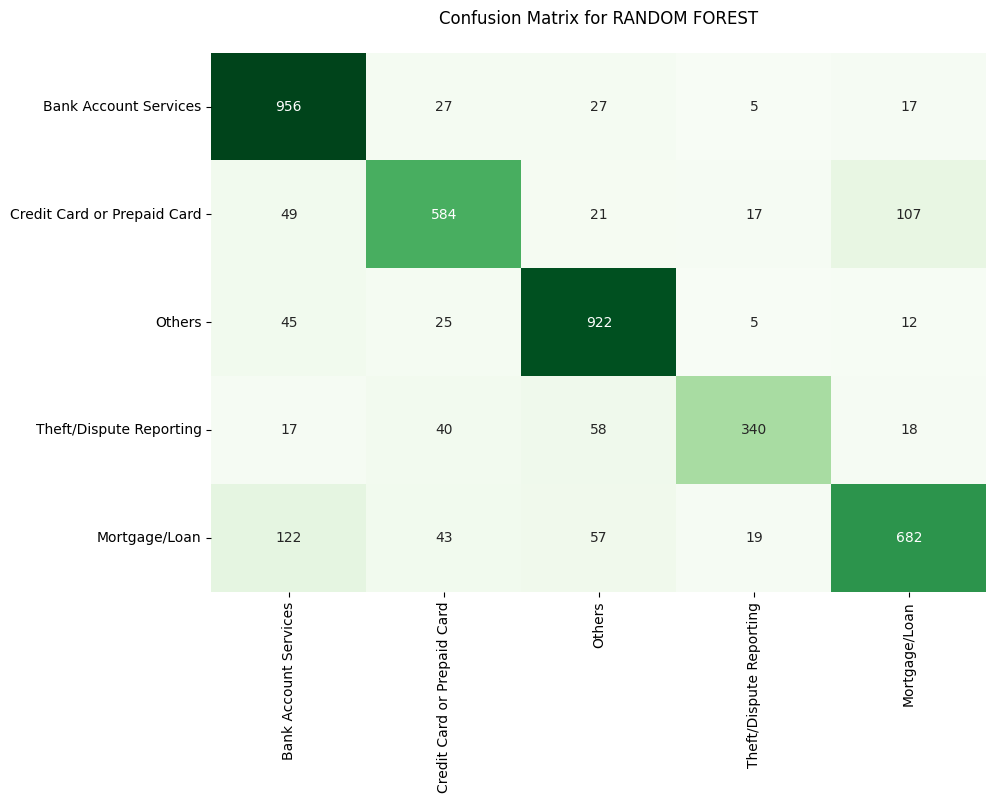

In [145]:
## Evaluating Decision Tree model
evaluate_model_performance(y_test, y_pred_rf_tuned, model_name)

In [146]:
# Updating the F1 score summary table with the score for Random Forest model
F1_summary.loc[len(F1_summary.index)] = ['Random Forest', round(F1_rf, 2)]
F1_summary

,Model,F1 Score
0,Naive Bayes,0.76
1,Logistic Regression,0.93
2,Decision Tree,0.77
3,Random Forest,0.80
4,Random Forest,0.82


## <font color= Green>Inference:</font>
After evaluating the model performaces above, we can safely say that Logistic Regression performs the best with an F1 score of 0.93

### Predicting on custom text using the best model: 

In [137]:
df_complaints = pd.DataFrame({
    'complaints': [
        "My loan payment was deducted twice this month, causing an overdraft. Please rectify this immediately.",
        "I have been trying to contact customer service regarding an unauthorized charge on my credit card, but no one is responding.",
        "How do I close my savings account without visiting the branch? Can this be done online?",
        "There seems to be an issue with my mortgage payment processing. I need assistance in resolving this.",
        "I received a notification about a loan application that I did not initiate. How can I secure my account?",
        "What is the procedure to update my contact information for my bank account?",
        "I need to know the current interest rates for fixed deposits in your bank."
    ]
})

print(df_complaints)

                                          complaints
0  My loan payment was deducted twice this month,...
1  I have been trying to contact customer service...
2  How do I close my savings account without visi...
3  There seems to be an issue with my mortgage pa...
4  I received a notification about a loan applica...
5  What is the procedure to update my contact inf...
6  I need to know the current interest rates for ...


In [138]:
# Define the prediction function for a the custom complaints
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = vec_count.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr_tuned.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [139]:
## # Apply the prediction function to each complaint
df_complaints['Topic'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,Topic
0,"My loan payment was deducted twice this month,...",Mortgage/Loan
1,I have been trying to contact customer service...,Others
2,How do I close my savings account without visi...,Account Services
3,There seems to be an issue with my mortgage pa...,Mortgage/Loan
4,I received a notification about a loan applica...,Mortgage/Loan
5,What is the procedure to update my contact inf...,Account Services
6,I need to know the current interest rates for ...,Account Services


## <font color= Green>Conclusion:</font>
Our Logistic Regression model sucessfully predicted the topics for the custom complaint samples. Thus, our model can efficiently classify customer complaints based on produts and services. 